In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow.python'

# Data Gathering and Preprocessing

In [4]:
#LOAD DATA
DIR = "/Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


# Model Training

In [5]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

12683000/12683000 [==============================] - 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 127s 3s/step - loss: 244.7641 - accuracy: 0.5664 - val_loss: 102.7822 - val_accuracy: 0.8067
Epoch 2/50
36/36 [==============================] - 129s 4s/step - loss: 45.6514 - accuracy: 0.7832 - val_loss: 11.2842 - val_accuracy: 0.6785
Epoch 3/50
36/36 [==============================] - 127s 3s/step - loss: 6.4900 - accuracy: 0.5640 - val_loss: 4.4126 - val_accuracy: 0.5503
Epoch 4/50
36/36 [==============================] - 130s 4s/step - loss: 4.1705 - accuracy: 0.5415 - val_loss: 4.0237 - val_accuracy: 0.5444
Epoch 5/50
36/36 [==============================] - 128s 3s/step - loss: 4.0344 - accuracy: 0.5310 - val_loss: 3.9549 - val_accuracy: 0.5523
Epoch 6/50
36/36 [==============================] - 140s 4s/step - loss: 3.9790 - accuracy: 0.5419 - val_loss: 3.8540 - val_accuracy: 0.5227
Epoch 7/50
36/36 [==============================] - 141s 4s/step - loss: 3.9187 - accuracy: 0.5441 - val_loss: 3.7915 - val_accuracy: 0.5168
Epoch 8/50
36/36 [

In [6]:
model.save("/content/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

# Model Evaluation

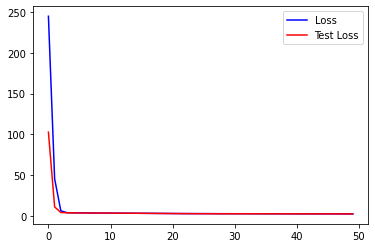

In [7]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

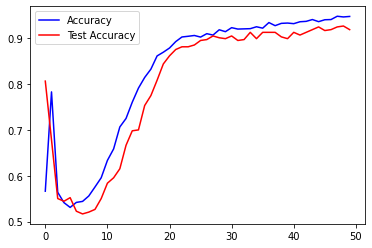

In [8]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

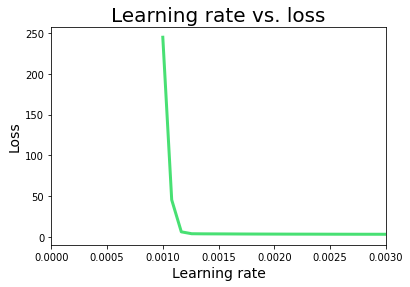

In [9]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 0s 41ms/step
[90.68871     1.1755617   0.80518025  0.6742774   0.630303    3.834998
  1.1983337   0.42686546  0.56576455] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Aluminium 90.68871140480042%


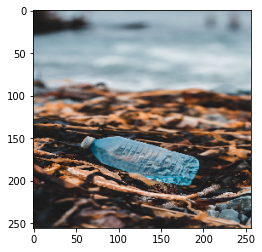

In [15]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1586041828039-b8d193d6d1dc?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 47ms/step


<Figure size 720x720 with 0 Axes>

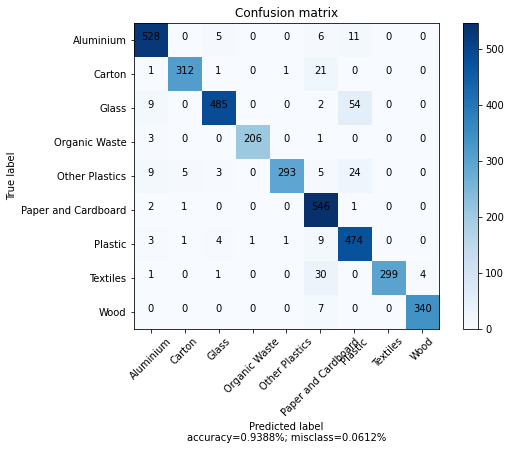

In [11]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

# Advanced Filter Visualization

1/1 [==============================] - 0s 45ms/step


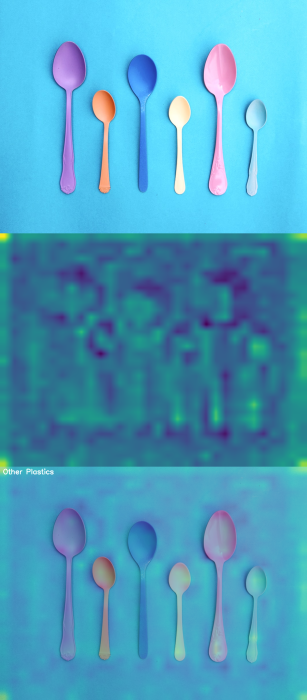

In [12]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)